In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from img_utils import *

2024-05-02 09:07:50.842071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 09:07:50.842127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 09:07:50.842956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 09:07:50.848487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 09:07:51.859693: W tensorflow/compiler/tf2

# Loading Data 

In [3]:
path = "../nybolig-scrape/output_raw"
# path = "../nybolig-scrape/output_old"
# path = "../nybolig-scrape/output/part_2"
# path = "../nybolig-scrape/output/stylized_part_1"
houses_df = data_to_DF_old(path)
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))  # TODO: Try including houses that dont have energy label and other missing data
display(houses_df.head())

Number of datapoints of type 'Ejerlejlighed':  890


,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,lat,lng,postal_avg_sqm_price,image_floorplan
0,https://www.nybolig.dk/ejerlejlighed/1867/acac...,Acaciavej 1 1. 1867 Frederiksberg C,1867,ejerlejlighed,9995000,124,None,4.0,1875.0,2022.0,B,55.678522749037,12.5397212034588,0.00,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,https://www.nybolig.dk/ejerlejlighed/2610/ager...,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1945000,70,None,2.0,1968.0,NaN,D,56.5753563308919,8.2055979563106,33273.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,https://www.nybolig.dk/ejerlejlighed/2610/ager...,Agerskovvej 4M st. 2610 Rødovre,2610,ejerlejlighed,2195000,70,None,2.0,1968.0,NaN,D,56.5753563308919,8.2055979563106,33273.25,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,https://www.nybolig.dk/ejerlejlighed/2100/agge...,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3.0,1896.0,1933.0,D,55.6992221443005,12.5868488817465,55737.75,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,https://www.nybolig.dk/ejerlejlighed/2700/agge...,Aggersvoldvej 3B 3. 2700 Brønshøj,2700,ejerlejlighed,2725000,66,None,3.0,1934.0,NaN,C,55.6965483017383,12.5003343598185,33507.50,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Setting up splits

In [4]:
from sklearn.model_selection import train_test_split

# Remove outliers
houses_df = remove_outliers(houses_df, "price", z_score_threshold=2)

#Drop houses with no floorplan
houses_df = houses_df.dropna(subset=['image_floorplan'])

# Drop "url" column
houses_df = houses_df.drop(columns=['url'])

#Set the basement_size to 0 if it is NaN
houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

#Set the year_rebuilt to year_built if it is NaN
houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])

#Encode the features: postal_code, type, energy_class
houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
houses_df['type'] = houses_df['type'].astype('category').cat.codes
houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

# Drop any NaN values
houses_df = houses_df.dropna()
print("Number of  datapoints: ", len(houses_df))

# Drop rows with "longitude" or "latitude" set to 0
houses_before = len(houses_df)
houses_df = houses_df[(houses_df["lng"] != 0) & (houses_df["lat"] != 0)]

# Print the number of datapoints removed
print(f"{houses_before - len(houses_df)} datapoints removed")
print("Number of Datapoints after removing 0 coordinates: ", len(houses_df))

# Average price of houses
AVERAGE_PRICE = houses_df["price"].mean()

# Split the data into train, validation and test sets with a 60-20-20 ratio
train1_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train1_df, valid_df = train_test_split(train1_df, test_size=0.2, random_state=0)
train1_df, train2_df = train_test_split(train1_df, test_size=0.5, random_state=0)

# Print first 5 entries of both train_df_unused and train_df
print("train2_df (unused):")
print(train2_df.head())
print("train1_df:")
print(train1_df.head())
print("test_df:")
print(test_df.head())

print("Number of datapoints in train set: ", len(train1_df))

/tmp/ipykernel_4211/3859307433.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  houses_df['basement_size'] = houses_df['basement_size'].fillna(0)


Number of  datapoints:  842
51 datapoints removed
Number of Datapoints after removing 0 coordinates:  791
train2_df (unused):
                                          address  postal_code  type    price  \
543            Nyhavn 12D 1. mf. 1051 København K            0     0  5795000   
373      Islands Brygge 54 1. tv 2300 København S           69     0  7500000   
826  Victor Bendix Gade 16 1. tv 2100 København Ø           66     0  4695000   
50         Baune Alle 2 st. c 2800 Kongens Lyngby           94     0  4395000   
224      Flensborggade 23 2. tv. 1669 København V           43     0  3695000   

     size  basement_size  rooms  year_built  year_rebuilt  energy_label  \
543    88              0    2.0      1780.0        1780.0             6   
373   101              0    3.0      2019.0        2019.0             2   
826    79              0    4.0      1968.0        1968.0             4   
50    112              0    3.0      2010.0        2010.0             3   
224    56   

In [5]:
def scale_by_size(canvas_size, house_sizes, images, max_house_size):
  """
  Create a canvaz, and fit the images corresponding to the house size on the canvas and max_house_size
  """
  canvases = []
  for house_size, image in zip(house_sizes, images):
    #Create a canvas
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8)
    #Scale the image
    scale = (house_size/max_house_size)
    new_width = int(image.shape[1] * scale)
    new_height = int(image.shape[0] * scale)
    #Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    #Place the image in the center of the canvas
    x_offset = int((canvas_size - new_width) / 2)
    y_offset = int((canvas_size - new_height) / 2)
    canvas[y_offset:y_offset+resized_image.shape[0], x_offset:x_offset+resized_image.shape[1]] = resized_image
    # turn the canvas background to white
    canvas[canvas == 1] = 255
    canvases.append(canvas)
  # Return the canvases as a numpy array
  return np.array(canvases)

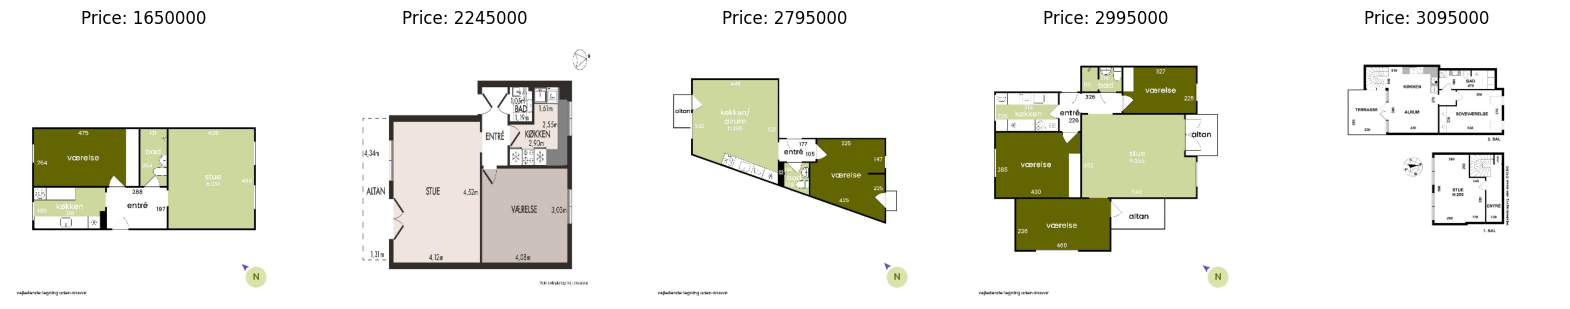

In [6]:
target_width = 448
target_height = 448
# target_width = 224
# target_height = 224

resize: bool = True
gray_scale: bool = False
threshhold: bool = False

train_images_RGB = preprocess_images(train1_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
max_house_size = max(train1_df['size'].max(), valid_df['size'].max(), test_df['size'].max())

train_prices = train1_df['price']
validation_prices = valid_df['price']
test_prices = test_df['price']

#Plot the first 5 images and their prices 
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Price: {train_prices.iloc[i]}")
    ax[i].axis('off')
plt.show()


# Model Fitting

In [7]:
from tensorflow.keras.applications import (
    VGG16,
    EfficientNetB3,
    EfficientNetB4,
    InceptionResNetV2,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from multiprocessing import Process, Queue

USED_MODEL = VGG16
MODEL_NAME = "VGG16_regression_model"


def train_model(fine_tune_layers: int = 0):
    """
    Train a model with the VGG16 architecture and save the model to disk.

    Args:
        fine_tune_layers (int): Number of layers to fine-tune, counting from the top of the model.
    """
    set_gpu()

    # Load pre-trained VGG16 model (excluding top layers)
    input_shape = train_images_RGB[0].shape
    base_model = USED_MODEL(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    # Freeze the pre-trained layers
    for layer in (
        base_model.layers[:-fine_tune_layers]
        if fine_tune_layers > 0
        else base_model.layers
    ):
        layer.trainable = False

    # Add new top layers for regression
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1),
        ]
    )

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1), loss="mean_absolute_error")
    model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    )
    history = model.fit(
        train_images_RGB,
        train_prices,
        validation_data=(validation_images_RGB, validation_prices),
        epochs=100,
        callbacks=[early_stopping],
    )

    model.save(f"./{MODEL_NAME}")

    # Plot the training history
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.show()

In [8]:
# VGG16
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, True
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.35
# # Mean Absolute Error: 1111833.93
# # Mean Squared Error: 2164829315237.49
# #
# # scaled_to_size = True
# # resize, gray_scale, threshhold = True, False, True
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.45
# # Mean Absolute Error: 1044472.14  # Does not perform well in ensemble
# # Mean Squared Error: 1824225972428.69
# #
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.44
# # Mean Absolute Error: 1055607.22
# # Mean Squared Error: 1816447247570.52
# #
# # stylized = True
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.40
# # Mean Absolute Error: 1024576.98
# # Mean Squared Error: 1897059053568.04

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# # learning_rate = 1
# # epochs = 100
# # patience = 10
# # results:
# # R2 score: -0.81
# # Mean Absolute Error: 1779379.38
# # Mean Squared Error: 6009758915140.81
# #
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.32
# # Mean Absolute Error: 1155295.97
# # Mean Squared Error: 2252672991998.55

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# learning_rate = 1
# epochs = 100
# patience = 30
# results:
# R2 score: 0.32
# Mean Absolute Error: 1148088.31
# Mean Squared Error: 2265939360684.82

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(1024, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# learning_rate = 1
# epochs = 100
# patience = 10
# results:
# R2 score: 0.34
# Mean Absolute Error: 1127382.80
# Mean Squared Error: 2200280689245.28

# EfficientNetB3
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.42
# # Mean Absolute Error: 1031535.84
# # Mean Squared Error: 1858363359685.06

# # fine_tune_layers = 10
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.41
# # Mean Absolute Error: 1047578.58
# # Mean Squared Error: 1986159298565.42

# # fine_tune_layers = 50
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.31
# # Mean Absolute Error: 1095999.87
# # Mean Squared Error: 2342962266733.80

# EfficientNetB4
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.38
# # Mean Absolute Error: 1061604.04
# # Mean Squared Error: 1989660041675.49

# InceptionResNetV2
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# # scaled_to_size = False
# # resize, gray_scale, threshhold = True, False, False
# # learning_rate = 1
# # epochs = 100
# # patience = 30
# # results:
# # R2 score: 0.09
# # Mean Absolute Error: 1230078.76
# # Mean Squared Error: 2922946910885.39

# Model Evaluation

In [9]:
def evaluate_model(queue: Queue):
    set_gpu()
    
    # Evaluate the model
    loaded_model = tf.keras.models.load_model(f"./{MODEL_NAME}")
    loaded_model.evaluate(test_images_RGB, test_prices)
    predictions = loaded_model.predict(test_images_RGB)
    
    queue.put(predictions)

In [10]:
from IPython.display import clear_output
import time

def median_error_rate(runs: int = 1):
    """
    Calculate the median error rate of the model.
    
    Args:
        runs (int): Number of times to run the evaluation.
    """
    start_time = time.time()

    predictions = []
    mse_scores = []
    mae_scores = []
    r2_scores = []
    for _ in range(runs):
        print(f"Run {_ + 1}/{runs}")
        p = Process(target=train_model, args=(0,))
        p.start()
        p.join()

        queue = Queue()
        p = Process(target=evaluate_model, args=(queue,))
        p.start()
        p.join()
        predictions.append(queue.get())

        # Clear the cmd output
        clear_output(wait=True)

    # Calculate the median error rate
    for prediction in predictions:
        mse_scores.append(mse(test_prices, prediction))
        mae_scores.append(mae(test_prices, prediction))
        r2_scores.append(r2_score(test_prices, prediction))

    print(f"Time elapsed: {time.time() - start_time:.2f} seconds")
    print(f"Median error scores of {runs} runs:")
    print(f"Mean Squared Error: {np.median(mse_scores)}")
    print(f"Mean Absolute Error: {np.median(mae_scores)}")
    print(f"R2 score: {np.median(r2_scores)}")

    print(f"Best error scores of {runs} runs:")
    print(f"Mean Squared Error: {np.min(mse_scores)}")
    print(f"Mean Absolute Error: {np.min(mae_scores)}")
    print(f"R2 score: {np.max(r2_scores)}")

    print(f"Worst errors scores of {runs} runs:")
    print(f"Mean Squared Error: {np.max(mse_scores)}")
    print(f"Mean Absolute Error: {np.max(mae_scores)}")
    print(f"R2 score: {np.min(r2_scores)}")

    # Median error rate of the model, meaning 

median_error_rate(1)

Time elapsed: 541.84 seconds
Median error scores of 1 runs:
Mean Squared Error: 2040482147987.5168
Mean Absolute Error: 1126604.9166666667
R2 score: 0.3957002078475923
Best error scores of 1 runs:
Mean Squared Error: 2040482147987.5168
Mean Absolute Error: 1126604.9166666667
R2 score: 0.3957002078475923
Worst errors scores of 1 runs:
Mean Squared Error: 2040482147987.5168
Mean Absolute Error: 1126604.9166666667
R2 score: 0.3957002078475923


In [11]:
# VGG16
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# epochs = 60
# patience = 20
# results:
# Median error scores of 11 runs:
# Mean Squared Error: 2063775882815.9504
# Mean Absolute Error: 1140173.1297169812
# R2 score: 0.38880164265839967
# Best error scores of 11 runs:
# Mean Squared Error: 1984711456361.2192
# Mean Absolute Error: 1129642.9772012578
# R2 score: 0.41221699893601593
# Worst errors scores of 11 runs:
# Mean Squared Error: 2141568258446.1057
# Mean Absolute Error: 1153663.9048742137
# R2 score: 0.3657630110924682
# Median error rate of 11 runs: 30.84%

# EfficientNetB3
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1)
# ])
# epochs = 60
# patience = 20
# results:
# Median error scores of 11 runs:
# Mean Squared Error: 2360623388508.818
# Mean Absolute Error: 1146907.4205974843
# R2 score: 0.3008886529916761
# Best error scores of 11 runs:
# Mean Squared Error: 2070920124287.8896
# Mean Absolute Error: 1104401.448899371
# R2 score: 0.38668583701862114
# Worst errors scores of 11 runs:
# Mean Squared Error: 3551561140851.894
# Mean Absolute Error: 1342064.0990566039
# R2 score: -0.05181398492024303
# Median error rate of 11 runs: 31.02%

1 Physical GPUs, 1 Logical GPU


2024-05-02 09:18:02.798447: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:02.820488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:02.820590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:02.823529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:02.823843: I external/local_xla/xla/stream_executor

5/5 [==============================] - 2s 351ms/step
R2 score: 0.40
Mean Absolute Error: 1126604.92
Mean Squared Error: 2040482147987.52


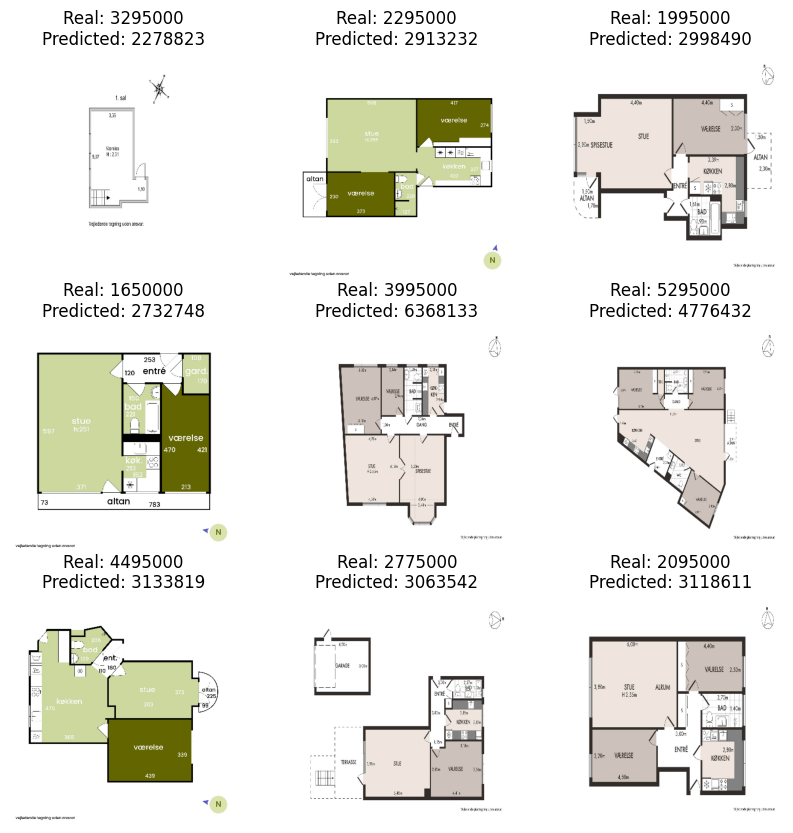

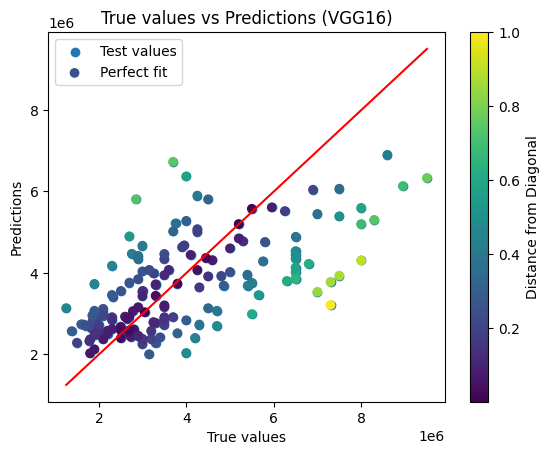

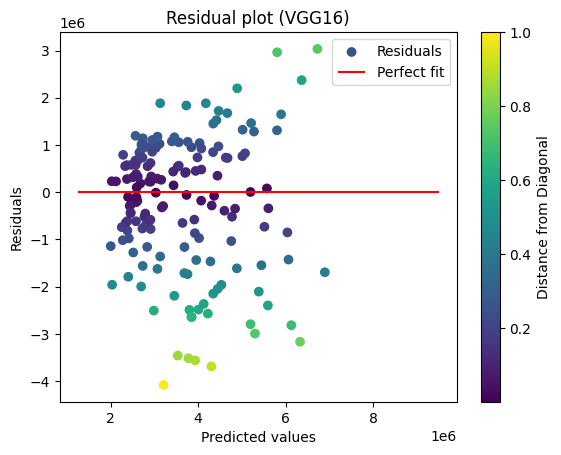

In [12]:
queue = Queue()
p = Process(target=evaluate_model, args=(queue,))
p.start()
p.join()

if queue.empty():
    raise ValueError("Nothing was returned from the process")
predictions = queue.get()
real_prices = test_df['price'].values
predicted_prices = predictions.flatten()

# Print the R2 score, MAE and MSE
print(f"R2 score: {r2_score(real_prices, predicted_prices):.2f}")
print(f"Mean Absolute Error: {mae(real_prices, predicted_prices):.2f}")
print(f"Mean Squared Error: {mse(real_prices, predicted_prices):.2f}")

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[0:9], test_df["price"][0:9], predictions[0:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction[0]:.0f}")
    plt.axis("off")

plt.show()

# Plot the predictions vs real prices
plot_regression_results('VGG16', real_prices, predicted_prices)

# Visualizing Predictions

## Saliency

2024-05-02 09:18:55.088398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.109097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.109193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.112432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.112557: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-05-02 09:18:55.294929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.295057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.295073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-05-02 09:18:55.295127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-02 09:18:55.295144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

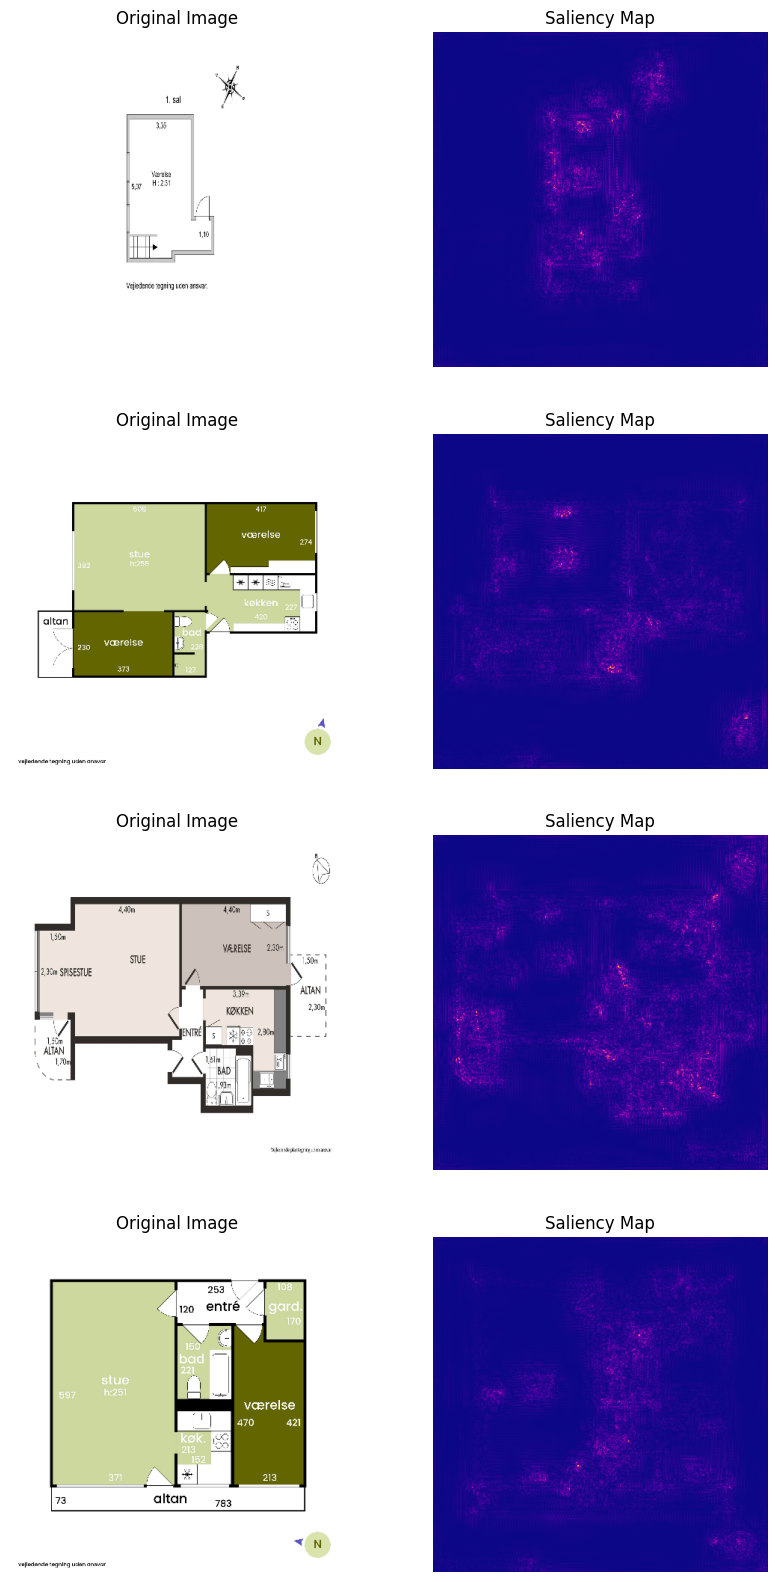

In [13]:
import numpy as np

def get_saliency_maps(images: np.ndarray):
    set_gpu()
    model = tf.keras.models.load_model(f"./{MODEL_NAME}")
    saliency_maps = []
    for image in images:
        with tf.GradientTape() as tape:
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            image = tf.expand_dims(image, axis=0)
            tape.watch(image)
            predictions = model(image)

        # Compute gradients of the output with respect to the input image
        gradient = tape.gradient(predictions, image)
        
        # Take absolute value of gradients to get saliency map
        saliency_map = tf.abs(gradient)
        
        # Reshape saliency map
        saliency_map = tf.reshape(saliency_map, image.shape[1:])  # Remove batch dimension
        
        # Normalize between 0 and 1
        saliency_map /= tf.reduce_max(saliency_map)

        # Set color channels to 0
        saliency_map = saliency_map[:, :, 0]

        saliency_maps.append(saliency_map)

    return saliency_maps

def plot_saliency_maps(images):
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
    saliency_maps = get_saliency_maps(images)

    if len(images) > 1:
        for i, image in enumerate(images):
            # Plot the original image
            axes[i, 0].imshow(image)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")
            
            # Plot the saliency map
            axes[i, 1].imshow(saliency_maps[i], cmap="plasma")
            axes[i, 1].set_title("Saliency Map")
            axes[i, 1].axis("off")
    else:
        # Plot the original image
        axes[0].imshow(images[0])
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        # Plot the saliency map
        axes[1].imshow(saliency_maps[0], cmap="plasma")
        axes[1].set_title("Saliency Map")
        axes[1].axis("off")

    plt.show()

n_images = 4

p = Process(target=plot_saliency_maps, args=(test_images_RGB[:n_images],))
p.start()
p.join()

## Class Activation Maps (doesn't work, WIP)

In [14]:
# from tensorflow.keras import backend as K

# def get_class_activation_maps(images: np.ndarray):
#     set_gpu()
#     model = tf.keras.models.load_model("./VGG16_regression_model")
#     classifier_layer = model.get_layer("dense_2")
#     base_model = model.get_layer("vgg16")
#     last_conv_layer = base_model.get_layer("block5_conv3")

#     class_activation_maps = []
#     for image in images:
#         # Convert the image to a tensor of type float32
#         image = tf.convert_to_tensor(image, dtype=tf.float32)
#         image = tf.expand_dims(image, axis=0)

#         # Get the model's prediction
#         predictions = model(image)

#         # Get the class with the highest probability
#         predicted_class = tf.argmax(predictions[0]).numpy()

#         # Get the output of the classifier layer for the predicted class
#         class_out = model.output[:, predicted_class]

#         # Get the output of the last convolutional layer
#         last_conv_output = last_conv_layer.output

#         with tf.GradientTape() as tape:
#             # Compute the gradient of the class output value with respect to the feature map
#             grads = tape.gradient(class_out, last_conv_output)

#         # Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature map channel
#         pooled_grads = K.mean(grads, axis=(0, 1, 2))

#         # Multiply each channel in the feature map array by "how important this channel is" with regard to the class
#         last_conv_output_value = last_conv_output[0].numpy()
#         pooled_grads_value = pooled_grads.numpy()
#         for i in range(512):
#             last_conv_output_value[:, :, i] *= pooled_grads_value[i]

#         # The channel-wise mean of the resulting feature map is our class activation map
#         class_activation_map = np.mean(last_conv_output_value, axis=-1)

#         # Normalize between 0 and 1
#         class_activation_map -= np.min(class_activation_map)
#         class_activation_map /= np.max(class_activation_map)

#         class_activation_maps.append(class_activation_map)

#     return class_activation_maps

# def plot_class_activation_maps(images):
#     fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
#     class_activation_maps = get_class_activation_maps(images)

#     if len(images) > 1:
#         for i, image in enumerate(images):
#             # Plot the original image
#             axes[i, 0].imshow(image)
#             axes[i, 0].set_title("Original Image")
#             axes[i, 0].axis("off")
            
#             # Plot the class activation map
#             axes[i, 1].imshow(class_activation_maps[i], cmap="plasma")
#             axes[i, 1].set_title("Class Activation Map")
#             axes[i, 1].axis("off")
#     else:
#         # Plot the original image
#         axes[0].imshow(images[0])
#         axes[0].set_title("Original Image")
#         axes[0].axis("off")
        
#         # Plot the class activation map
#         axes[1].imshow(class_activation_maps[0], cmap="plasma")
#         axes[1].set_title("Class Activation Map")
#         axes[1].axis("off")

#     plt.show()

# p = Process(target=plot_class_activation_maps, args=(test_images_RGB[:n_images],))
# p.start()
# p.join()

: 